### Patient readmission project

The aim of this project is to create the machine learning model that could predict whether the given patient would be readmitted to the hospital based on patient collected data. The model will be tuned using ray, orchestrated using AIR-FLow and deployed on HuggingFace, as well as connected to the website, where one could ask questions about the dataset and get the answers from an LLM.

### Import libraries

In [97]:

# standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight


### Import data

In [4]:

# get the data
data=pd.read_csv('/home/ec2-user/projects/patient_selection/data/diabetic_data.csv')


### Exploratory Data Analysis

In this part we will plot the distributions of numeric and categorical variables.
Plot their relationships to have a better idea of the dataset structure.

In [18]:

# show the data
data.head(3)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


### Plot a few example features

Text(0, 0.5, 'Features')

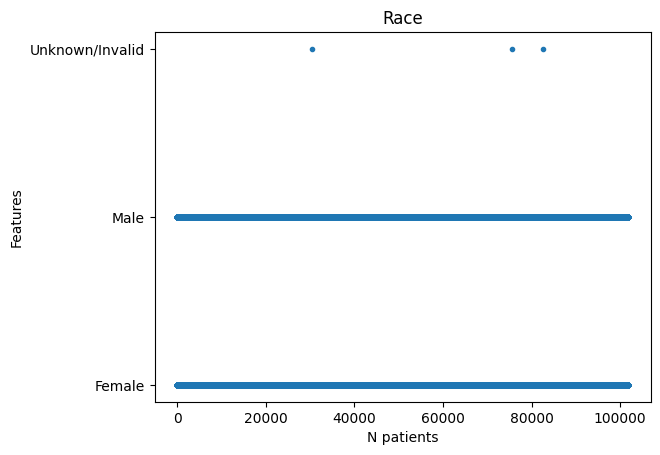

In [41]:

plt.plot(data['gender'],'.')
plt.title('Race')
plt.xlabel('N patients')
plt.ylabel('Features')


#### Observation

(i) If feature is not present -> it is replaced by Unknown/Invalid value. The same pattern is seen for many features

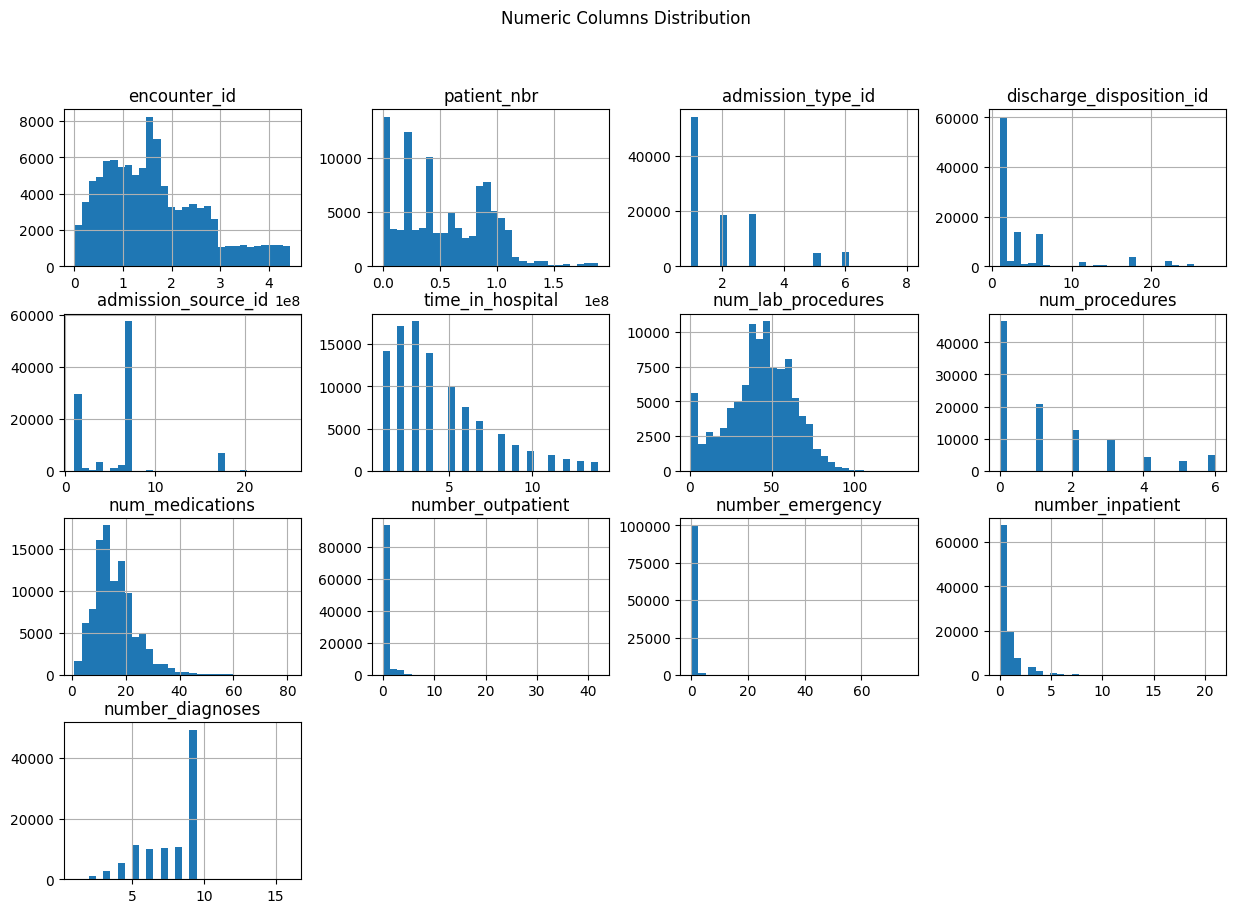

In [ ]:

# Plot numeric columns
num_cols = data.select_dtypes(include="number").columns
data[num_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Numeric Columns Distribution")
plt.show()


#### Observations:

(i) We could see that multiple features (num_lab_procedures, num_medications) and close to normally distributed
(ii) However the majority of other features (number_diagnoses, number_inpatient) are not normally distibuted

It is likely that many of these distributions are not normal, which hints that non-linear methods might help to find patterns in the data.


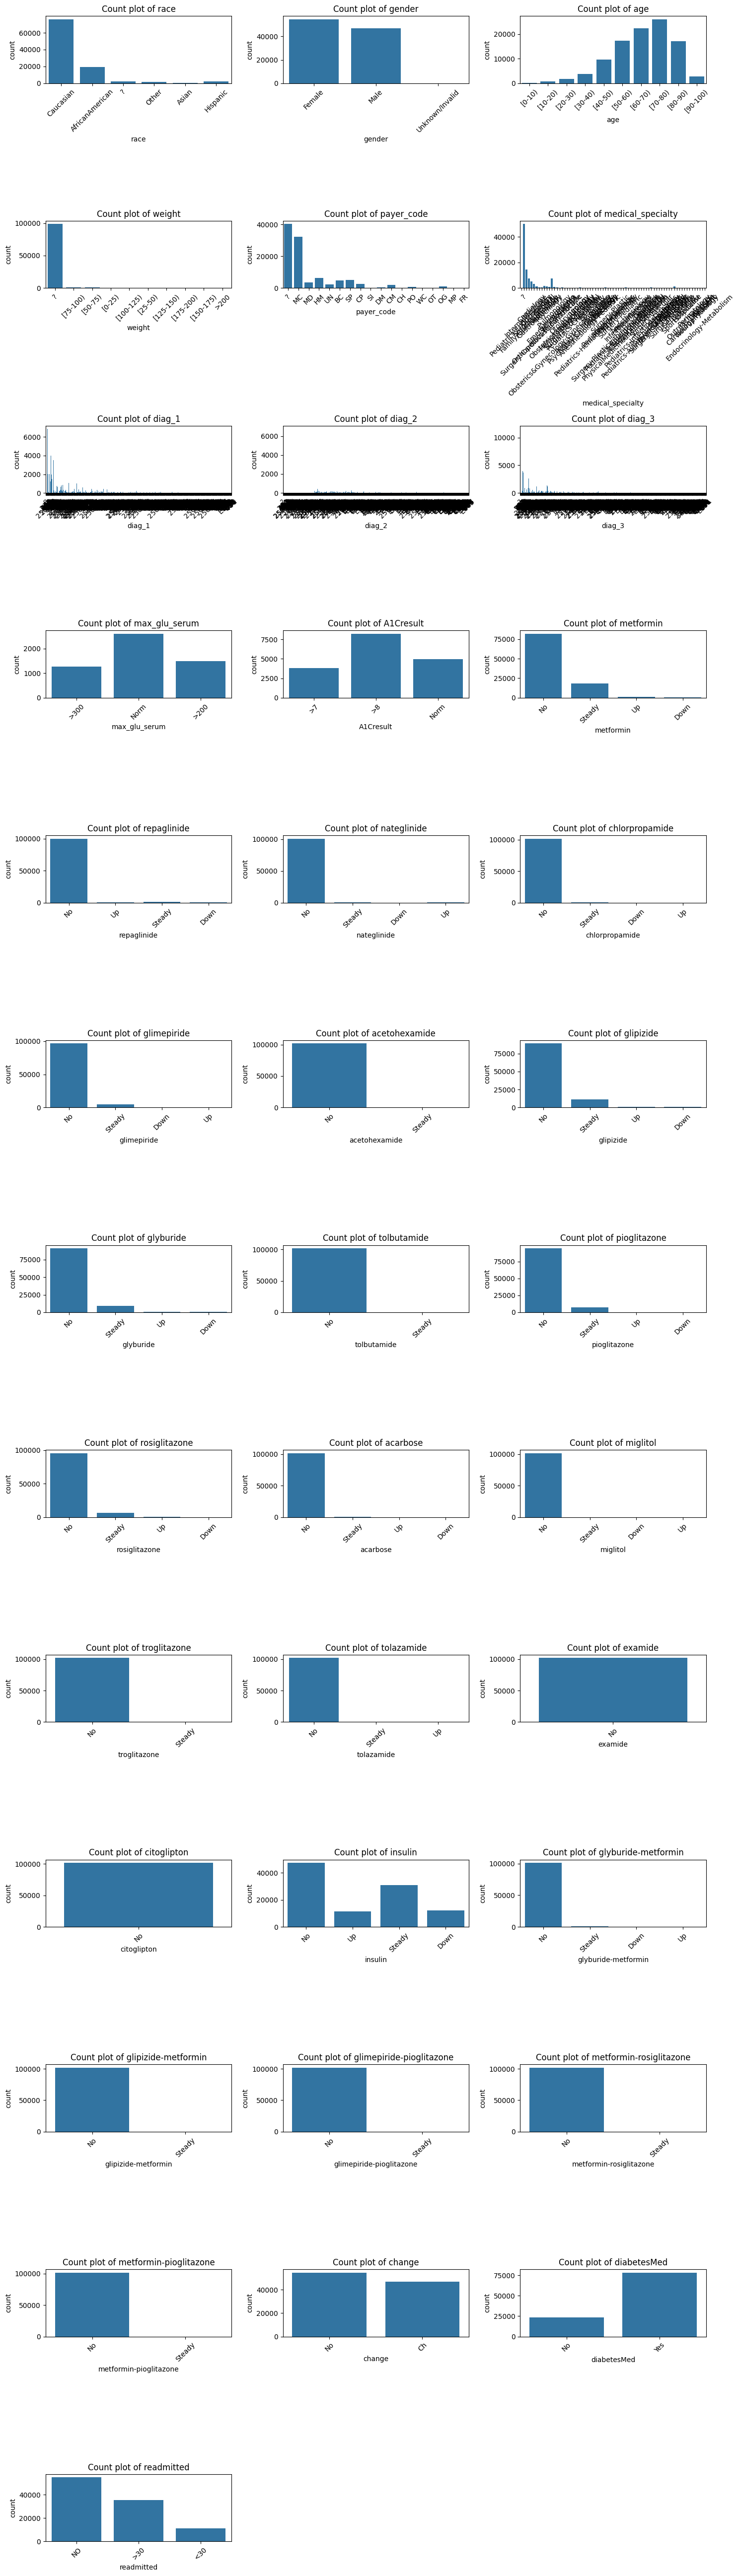

In [17]:

# Get all categorical columns
cat_cols = data.select_dtypes(include="object").columns

# Define grid size
n_cols = 3  # number of plots per row
n_rows = math.ceil(len(cat_cols) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=data, x=col, ax=axes[i])
    axes[i].set_title(f"Count plot of {col}")
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplots (if number of columns is not a multiple of n_cols)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Observations:

(i) Most of patients are Caucasian, with small amount of other race groups

(ii) Age distributino seems to be requally distributed across different groups

(iii) The distributions of drug usage is quite un-equal, when some patients have taken the drugs, while some did not


### Data split

In this part we will split the dataset to have equal representations of readmitted and not-readmitted patients. The goal is to split the dataset into: train, test, validation sets. As well as keep half of the training dataset for model running the model re-training, in case of drift that could be detected.

In [68]:

data.head(5)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [61]:

# data split
X=data
y=data['readmitted']

# drop the target
X = X.drop("readmitted", axis=1)

# replace categorical features with one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y ,test_size=0.2, random_state=42)

# split into two parts
X_train_1, X_train_2 = X_train.iloc[:X_train.shape[0]//2], X_train.iloc[X_train.shape[0]//2:]
y_train_1, y_train_2 = y_train.iloc[:y_train.shape[0]//2], y_train.iloc[y_train.shape[0]//2:]


### Model development

In this part we will fit a couple of ML models to see how well we could predict patient readmissions.

##### Random forest model

In this model we will use Random Forest features to extract everything.

In [74]:

# random forest model

rf = RandomForestClassifier(
    n_estimators=200,    # number of trees
    max_depth=None,      # let trees expand fully
    class_weight="balanced",
    random_state=42,
    n_jobs=-1            # use all CPU cores
)

# oversample the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# train the model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.587452097867741

Classification Report:
               precision    recall  f1-score   support

         <30       0.30      0.05      0.08      2272
         >30       0.51      0.39      0.45      7109
          NO       0.62      0.82      0.71     10973

    accuracy                           0.59     20354
   macro avg       0.48      0.42      0.41     20354
weighted avg       0.55      0.59      0.55     20354


Confusion Matrix:
 [[ 106  872 1294]
 [ 140 2804 4165]
 [ 109 1817 9047]]


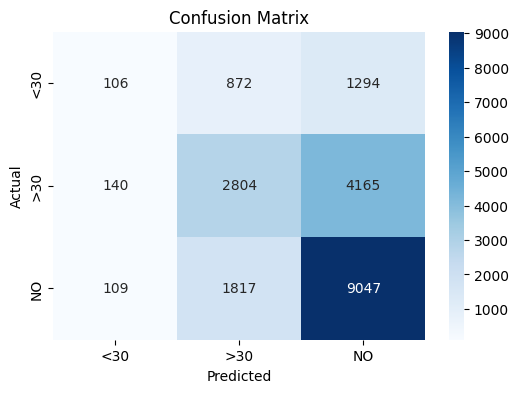

In [76]:

# vizualise the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_,
            yticklabels=rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


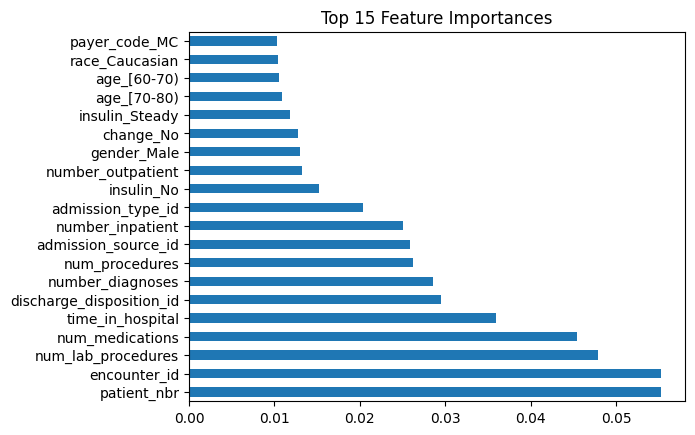

In [77]:

# evaluate the feature importance
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind="barh")
plt.title("Top 15 Feature Importances")
plt.show()


In [82]:

# Define the full path where you want to save the model
file_path = '/home/ec2-user/projects/patient_selection/model/rf.pkl' # Renamed for clarity

try:
    # 1. Use 'file_path' instead of the undefined 'filename'
    with open(file_path, 'wb') as file:
        pickle.dump(rf, file)
    
    # 2. Print the correct path that was used
    print(f"Model successfully saved to {file_path}")

except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Model successfully saved to /home/ec2-user/projects/patient_selection/model/rf.pkl


#### XgBoost classifier

### Model fine-tuning